# Steps to process and load Seabird SBE37 files to database

This process is divided into two parts: 

1. Processing of decoded Hex files using the Seabird Data Processing software.
2. Data Wrangling: Mering and tidying up of all converted files and loading to database using *Jupyter Notebook*

## Seabird Data Processing

1. Install Seabird Data Processing software - SBEDataProcessing-Win32 (Skip if already installed). Click on the below link to download and install software. 

    Download Link: https://www.seabird.com/asset-get.download.jsa?code=251838
    
    Manual Link: https://www.seabird.com/asset-get.download.jsa?code=251446
    
    
2. Once the software is installed, launch Seabird Data Processing software - SBEDataProcessing-Win32. 


3. Click on the *Run* menu and select *1. Data Conversion* option

    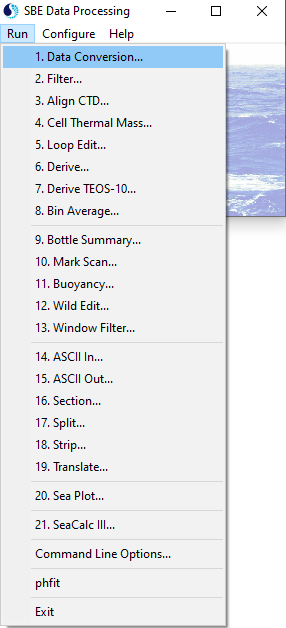
    
4. This will open the *Data conversion* dialog box. 
    
    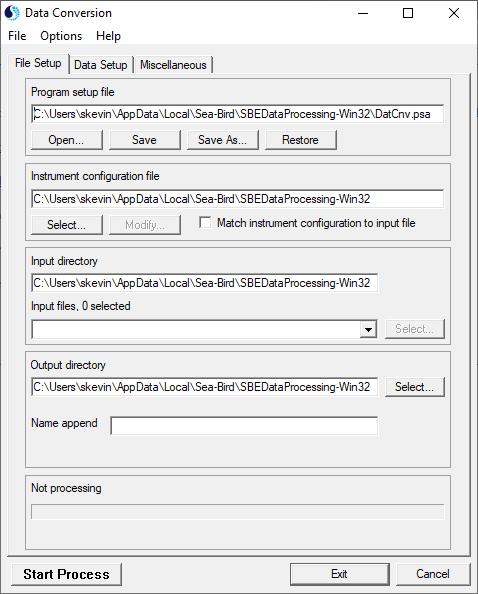
    
5. Setting in File Setup tab
   
   a. Select *Instrument configuration file*. In the file explorer pop-up, parse to the location of downloaded files and select the configuration file.  
   
   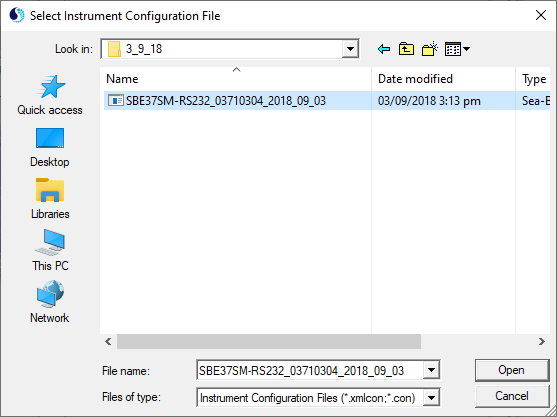
   
   b. Select *input file*. In the file explorer pop-up, select *Hex* file for processing.
   
   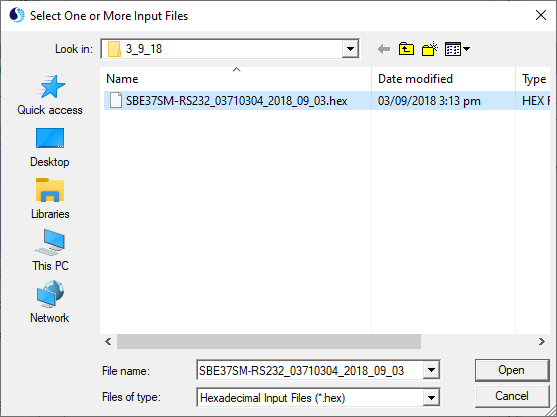
   
   c. The location of the output file can be changed by selecting a different output directory in the *File Setup* tab. It is recommended to create a new folder for storing all converted files. It would be easier to access the files in the steps if all the output files are stored in a single location.
   
   
6. Settings in Data Setup tab

    a. Press *Select Output Variables* button
    
    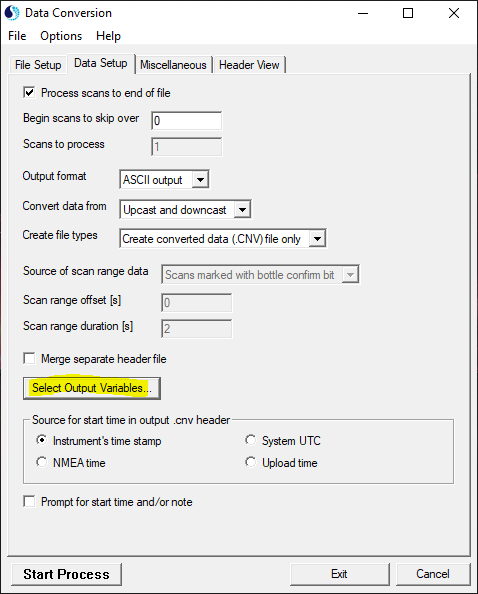
    
    b. Select *Time, Temperature and Salinity* (in the same order) as output variables
    
    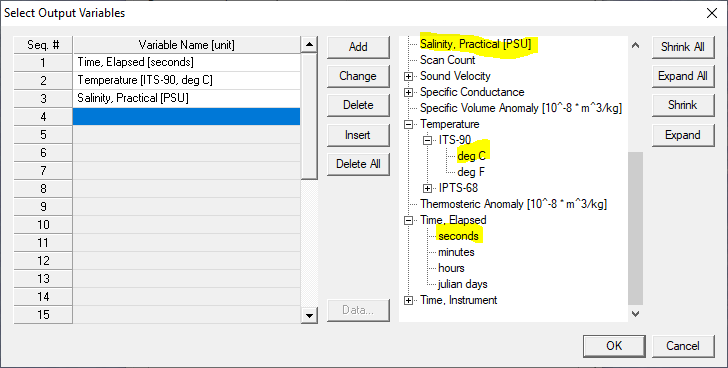
    
    
7. Once both File and Data setup are complete, press *Start Process* button. This will processing the Hex file as per the selected configuration and settings and generate a CNV file in the same folder location of the raw files.


8. Repeat the above steps for all the downloaded files. Once all the raw files are converted, press the *Run* button in this notebook to proceed to the next part of this process. 
    
## Jupyter Notebook

In [ ]:
#pip install seabird

import pandas as pd
from datetime import datetime, timedelta
import glob
import ipywidgets as widgets
import pyodbc
from ipyfilechooser import FileChooser
from sqlalchemy import create_engine
from seabird.cnv import fCNV

# establish connection to DB location
servername = 'midevsql01'
dbname = 'DATAMGT_interreg_compass'
username = 'compassadmin'
password = 'Compass@2021'
table_name = 'compass_seabird'


def round_minutes(dt):
    resolution = timedelta(minutes=1)
    dt = dt.strftime("%Y-%m-%d %H:%M:%S")
    dt = datetime.strptime(dt.split('.')[0], '%Y-%m-%d %H:%M:%S')
    dt = dt + (datetime.min - dt) % resolution
    return dt

def getDate(startDate,sec):
    dt = startDate + timedelta(seconds=sec)
    #dt = round_minutes(dt)
    return dt

def process(filepath):
    data = fCNV(filepath)
    metadataDf = pd.DataFrame([*data.attrs.values()]).T
    metadataDf.columns = [*data.attrs.keys()]
    df = pd.DataFrame(columns = ['time','temperature','salinity'])
    df['time'] = data["timeS"]
    df['time'] = df.apply(lambda row: getDate(metadataDf['datetime'][0],row['time']), axis=1)
    df['time'] = pd.to_datetime(df['time'],format='%Y-%m-%d', unit='s')
    df['temperature'] = data["tv290C"]
    df['salinity'] = data["PSAL"]
    
    return metadataDf,df

In [ ]:
fc = FileChooser()
display(fc)

In [ ]:
fileInfo, fileData = process(fc.selected)

In [ ]:
filename = fileInfo['filename'][0].split('.')[0]
print(filename)

In [ ]:
print("File Information")
display(fileInfo)
print("Data Information")
display(fileData.describe())
print("Data Preview")
display(fileData.head(20))

In [ ]:
fileData = fileData.sort_values(by=['time'])
fileData.to_csv(filename+'_processed.csv', index=False)

## Load to database

In [ ]:
print("Loading to database...")
conn = pyodbc.connect(driver='{ODBC Driver 17 for SQL Server}',
                      server=servername,
                      database=dbname,
                      uid=username, 
                      pwd=password)

insert_to_tmp_tbl_stmt = f"INSERT INTO {table_name} VALUES (?,?,?)"
cursor = conn.cursor()
cursor.fast_executemany = True
cursor.executemany(insert_to_tmp_tbl_stmt, fileData.values.tolist())
print(f'{len(fileData)} rows inserted to the {table_name} table')
cursor.commit()
cursor.close()
conn.close()
        
print("Load to database complete!")